# Neural Network Quantum State



In [1]:
import os
import json
import time
import sys

import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax
import ray
# import flax.linen as nn
import netket as nk
import netket.nn as nn

from scipy.sparse.linalg import eigsh
from netket.operator.spin import sigmaz, sigmax 
from ray import tune
from tqdm.autonotebook import tqdm
from IPython.display import display


/tmp/ipykernel_2689859/80669152.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from aklt_model import OurModel, setup_problem, setup_model, ray_train_loop 
#from j1j2_model import OurModel, setup_problem, setup_model, ray_train_loop 

In [3]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

skip_training = True
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=False


RayContext(dashboard_url='', python_version='3.8.10', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '130.233.224.199', 'raylet_ip_address': '130.233.224.199', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-27_17-40-23_093531_2689859/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-27_17-40-23_093531_2689859/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-27_17-40-23_093531_2689859', 'metrics_export_port': 61351, 'gcs_address': '130.233.224.199:55737', 'address': '130.233.224.199:55737', 'node_id': 'e1e867c56ba0135785f225206c141f60fddf1fc9ae1d7ebc015c4bbf'})

In [4]:
if not skip_training:
    from ray.tune.suggest.hyperopt import HyperOptSearch
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.08, 0.12),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        ray_train_loop,
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=50,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

### Select best model parameters

In [5]:
# TODO
hyperparams = {
    'model': {
        'alpha': 1
    },
    'learning_rate': 0.10,
    'n_epochs': 100,
    'n_samples': 1008,
}

H, hi, g, obs = setup_problem() #Remove the parameter for other models than j1j2. For j1j2 this chooses J2 when J1 = 1.0
eig_vals, _ = eigsh(H.to_sparse(), k=4, which="SA")
vstate, model, trainer = setup_model(H, hi, hyperparams)
display(f'{vstate.n_parameters=}')
log = nk.logging.RuntimeLog()  # CONTINUE: investigate the AKLT model and the custom Hamiltonian

'vstate.n_parameters=960'

In [6]:
#trainer.run(n_iter=hyperparams['n_epochs'], out=log, obs={'Neel': obs[0], 'sf': obs[1]})
trainer.run(n_iter=hyperparams['n_epochs'], out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

# Load the data from the results log
data = log.data

# Print out the result(s)
print("Analytic: {:.5f}\nRBMmV: {:.5f}\n".format(float(eig_vals[0]), jnp.real(data["Energy"].Mean)[-1] ))

100%|██████████| 100/100 [00:09<00:00, 10.69it/s, Energy=4.375971+0.000000j ± 0.000014 [σ²=0.000000, R̂=1.0121]]


Optimized energy and relative error:  4.375964+0.000000j ± 0.000014 [σ²=0.000000, R̂=1.0084] 4.000660747686997
Analytic: -1.45833
RBMmV: 4.37597



In [11]:
# TODO load saved model
if skip_training:
    pass

### Phase Diagram Loop

In [8]:
'''
Nsim = 1
import numpy as np
J2s = np.linspace(0.5, 0.8, num=Nsim)
Esim = np.zeros(Nsim)
Eacc = np.zeros(Nsim)
AFOPs = np.zeros(Nsim)
neelOPs = np.zeros(Nsim)
dimOPs = np.zeros(Nsim)
sigmas = np.zeros(Nsim)

hyperparams = {
    'model': {
        'alpha': 2
    },
    'learning_rate': 0.11,
    'n_epochs': 300,
    'n_samples': 1008,
}


for i in range(len(J2s)):
    #H, hi, obs = setup_problem(J2s[i]) 
    H, hi, obs = setup_problem() 
    vstate, model, trainer = setup_model(H, hi, hyperparams)
    log = nk.logging.RuntimeLog()
    eig_vals, _ = eigsh(H.to_sparse(), k=2, which="SA")
    Eacc[i] = eig_vals[0]
    
    print(obs)
    trainer.run(n_iter=hyperparams['n_epochs'], out=log, obs={'Neel': obs[0], 'AF': obs[1],'dimer': obs[2]})
    data = log.data
    
    # Different kinds of observables
    Eacc[i] = eig_vals[0]
    neelOPs[i] = jnp.mean(jnp.real(data['Neel'].Mean)[-50:-1])
    AFOPs[i] = jnp.mean(jnp.real(data['AF'].Mean)[-50:-1])
    Esim[i] = jnp.mean(jnp.real(data['Energy'].Mean)[-50:-1])
    sigmas[i] = jnp.mean(jnp.real(data['Energy'].Sigma)[-50:-1])
    dimOPs[i] = jnp.mean(jnp.real(data['dimer'].Mean)[-50:-1])
    #abs((Esim[i] - Eacc[i]) / Eacc[i])
'''

'\nNsim = 1\nimport numpy as np\nJ2s = np.linspace(0.5, 0.8, num=Nsim)\nEsim = np.zeros(Nsim)\nEacc = np.zeros(Nsim)\nAFOPs = np.zeros(Nsim)\nneelOPs = np.zeros(Nsim)\ndimOPs = np.zeros(Nsim)\nsigmas = np.zeros(Nsim)\n\nhyperparams = {\n    \'model\': {\n        \'alpha\': 2\n    },\n    \'learning_rate\': 0.11,\n    \'n_epochs\': 300,\n    \'n_samples\': 1008,\n}\n\n\nfor i in range(len(J2s)):\n    #H, hi, obs = setup_problem(J2s[i]) \n    H, hi, obs = setup_problem() \n    vstate, model, trainer = setup_model(H, hi, hyperparams)\n    log = nk.logging.RuntimeLog()\n    eig_vals, _ = eigsh(H.to_sparse(), k=2, which="SA")\n    Eacc[i] = eig_vals[0]\n    \n    print(obs)\n    trainer.run(n_iter=hyperparams[\'n_epochs\'], out=log, obs={\'Neel\': obs[0], \'AF\': obs[1],\'dimer\': obs[2]})\n    data = log.data\n    \n    # Different kinds of observables\n    Eacc[i] = eig_vals[0]\n    neelOPs[i] = jnp.mean(jnp.real(data[\'Neel\'].Mean)[-50:-1])\n    AFOPs[i] = jnp.mean(jnp.real(data[\'AF\']

In [9]:
'''
#save the results of above simualtion to file
res_concat = np.concatenate((J2s,Esim,Eacc,AFOPs,neelOPs,sigmas,dimOPs)).reshape((-1, 7), order='F')
#np.save("data/J1J2_L20_1layer_withdimer.npy",res_concat)
'''

'\n#save the results of above simualtion to file\nres_concat = np.concatenate((J2s,Esim,Eacc,AFOPs,neelOPs,sigmas,dimOPs)).reshape((-1, 7), order=\'F\')\n#np.save("data/J1J2_L20_1layer_withdimer.npy",res_concat)\n'

In [10]:
'''
#plt.plot(J2s, Eacc)
#plt.plot(J2s, Esim)
#plt.plot(J2s, neels)

fig,ax = plt.subplots()
# make a plot
#ax.plot(J2s, Eacc, color="red")
l1 =ax.plot(J2s, Esim, color="red" ,label="$E_0$ NNQS")
l2 =ax.scatter(J2s, Eacc, color="red",marker ="o" ,s=80, facecolors='none',label="$E_0$ Exact")
ax.set_xlabel("$J_2/\,J_1$",fontsize=14)
ax.set_ylabel("Ground state energy $E_0$", color="red",fontsize=14)
ax.legend()

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l4 =ax2.plot(J2s, AFOPs ,color="blue", label="AF OP")
l3 = ax2.plot(J2s, neelOPs ,'--',color="blue",label="Neel OP")
ax2.set_ylabel("Order Parameters",color="blue",fontsize=14)
ax2.legend(loc = (0.5,0.1))

# save the plot as a file
#fig.savefig('Figures/.pdf',format='pdf',bbox_inches='tight')
'''

'\n#plt.plot(J2s, Eacc)\n#plt.plot(J2s, Esim)\n#plt.plot(J2s, neels)\n\nfig,ax = plt.subplots()\n# make a plot\n#ax.plot(J2s, Eacc, color="red")\nl1 =ax.plot(J2s, Esim, color="red" ,label="$E_0$ NNQS")\nl2 =ax.scatter(J2s, Eacc, color="red",marker ="o" ,s=80, facecolors=\'none\',label="$E_0$ Exact")\nax.set_xlabel("$J_2/\\,J_1$",fontsize=14)\nax.set_ylabel("Ground state energy $E_0$", color="red",fontsize=14)\nax.legend()\n\nax2=ax.twinx()\n# make a plot with different y-axis using second axis object\nl4 =ax2.plot(J2s, AFOPs ,color="blue", label="AF OP")\nl3 = ax2.plot(J2s, neelOPs ,\'--\',color="blue",label="Neel OP")\nax2.set_ylabel("Order Parameters",color="blue",fontsize=14)\nax2.legend(loc = (0.5,0.1))\n\n# save the plot as a file\n#fig.savefig(\'Figures/.pdf\',format=\'pdf\',bbox_inches=\'tight\')\n'

## Results

Text(0, 0.5, 'Energy')

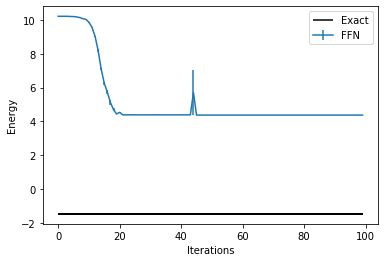

In [11]:
# Do plotting of the results
plt.errorbar(data["Energy"].iters, jnp.real(data["Energy"].Mean), yerr=data["Energy"].Sigma, label="FFN")
#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.hlines([eig_vals], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

In [12]:
sf=data['AF']
neel=data['Neel']

plt.plot(data["Energy"].iters, jnp.real(sf.Mean),  label= "Antiferromagnetic structure factor")
plt.plot(data["Energy"].iters, jnp.real(neel.Mean),  label= "Neel order parameter")
#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')


KeyError: 'AF'

### Wavefunctions

In [ ]:
ket = vstate.to_array()
plt.plot(abs(ket))


In [ ]:
# get quantum geometric tensor of state
# https://github.com/netket/netket/blob/2a7dded3db4705099d4de5450006b46b32ce34ca/netket/optimizer/qgt/qgt_onthefly_logic.py
#qgt = vstate.quantum_geometric_tensor()
#qgt

In [ ]:
#QGT = qgt.to_dense()
#qmetr = jnp.real(QGT)
#berry = jnp.imag(QGT)


In [ ]:
#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(berry)
#ax[1].imshow(qmetr)

# The AKLT Model

The AKLT model is an extension to the simple 1D Heisenberg spin model, proposed in 1987 by Affleck, I. et al.:

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799

The model is essentially a 1D chain of spin-1/2 nuclei which form pairs. A constraint of having two spin-1/2 nuclei for each site is further imposed, which leads to the system being effectively a spin-1 system. This can be understood then to be a chain of these spin-1 "composite" nuclei. 

In the ground state of this Hamiltonian, every dimerized pair is referred to as a site and is given by a 

The AKLT Hamiltonian is given by a linear combination of the spin-1 projection operators in the respective Hilbert space $$\mathcal{H} \subset \mathbb{C}^3$$.